In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import bernoulli
from tqdm import tqdm

In [2]:
def rbf(x,y,l_squared=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.zeros(dim)
    type_x = x.shape
    type_y = y.shape
    if len(type_x) == len(type_y):
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*l_squared))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*l_squared))
        return vect


In [3]:
mushrooms_whole = pd.read_csv('mushroom.csv')
classes_to_keep = mushrooms_whole['class'].copy()
colnames = mushrooms_whole.drop(['class'], axis=1).columns
mushrooms_whole = StandardScaler().fit_transform(X=mushrooms_whole.drop(['class'], axis=1).to_numpy())
mushrooms_whole = pd.DataFrame(mushrooms_whole)
mushrooms_whole.columns = colnames
mushrooms_whole['class'] = classes_to_keep
mushrooms, mushrooms_test = train_test_split(mushrooms_whole,train_size=0.05)
mushrooms = mushrooms.reset_index(drop=True)
mushrooms_test = mushrooms_test.reset_index(drop=True)

In [4]:
n_samples = mushrooms.shape[0]

In [5]:
mushrooms['label'] = np.zeros(n_samples)
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if mushrooms.loc[i,'class'] == 1 and random == 0:
        mushrooms.loc[i,'label'] = 1

n_cluster = 5
clustering = KMeans(n_clusters=n_cluster).fit(X=mushrooms.to_numpy()[:,:-2])
mushrooms['cluster'] = clustering.labels_

list_of_ratio = np.zeros(5)
for i in range(5):
    list_of_ratio[i] = mushrooms[mushrooms['cluster'] == i]['label'].sum()/mushrooms[mushrooms['cluster'] == i].shape[0]

positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(5)
for i in range(5):
    list_of_dist[i] = np.linalg.norm(clustering.cluster_centers_[positive_cluster,:] - clustering.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [6]:
for i in range(n_samples):
    if mushrooms.loc[i,'label'] == 0:
        mushrooms.loc[i,'label'] = -1

df_unlab_pop = mushrooms[mushrooms['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['class'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [7]:
reliable_positives = mushrooms[mushrooms['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = mushrooms[mushrooms['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = mushrooms[mushrooms['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = mushrooms[mushrooms['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

#let's now delete the useless variables for the next steps
del df_unlab_pop, list_of_pop, last_step, clustering, classes_to_keep
del list_of_dist, index_ordered_distance

In [8]:
reliable_negatives = reliable_negatives.sample(n=n_positives)

In [9]:
#little precision that is quite 'funny', they use a 'random svm' for the first step of classification of the unlabelled
#instances

In [10]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = mushrooms.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [11]:
gamma = 1
good_ratio = 1/2
max_iter = 1
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4]
results = first_step_clf.decision_function(X=up_data_np)
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in tqdm(range(n_samples)):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=2)*labels[0,i]*labels[0,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1)))

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    train_clf_data = pd.concat([reliable_positives,reliable_negatives])
    index_of_labels = list(train_clf_data.index)
    unlabelled_data = mushrooms.drop(labels=index_of_labels,axis=0)
    index_of_unlabelled = list(unlabelled_data.index)

    to_det_b = np.zeros(n_samples)
    for i in range(n_samples):
        to_det_b[i] = np.sum(alpha*labels*rbf(x=up_data_np,y=up_data_np[i,:]))

    b = np.sort(to_det_b)[int(good_ratio*n_samples)]
    
    check_array = np.zeros(n_samples)
    count_diff = 0
    
    for i in tqdm(range(n_samples)):
        if i in index_of_labels:
            check_array[i] = 1
        else:
            check_array[i] = np.sign(to_det_b[i]-b)
            if check_array[i] != updated_data.loc[i,'relab']:
                count_diff += 1

    if count_diff == 0:
        break
    else:
        updated_data['relab'] = check_array    

100%|██████████| 2701/2701 [00:00<00:00, 100490.66it/s]


In [12]:
positives = 0
true_positives = 0
for i in index_of_unlabelled:
    if updated_data.loc[i,'relab'] == 1:
        positives += 1
        if updated_data.loc[i,'class'] == 1:
            true_positives += 1
    

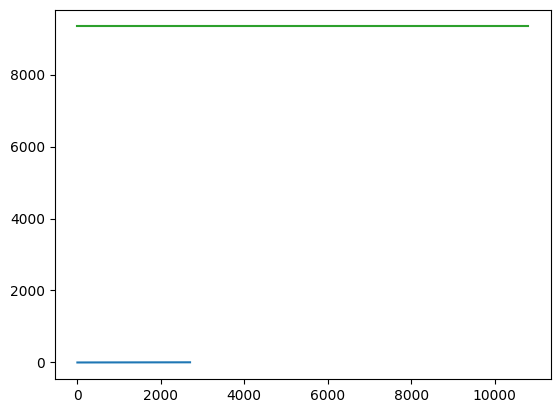

In [13]:
plt.plot(np.sort(results))
plt.plot(np.ones(2)*int(n_samples*good_ratio),np.linspace(-2,5,2))
plt.plot(np.linspace(0,10807,2),np.ones(2)*b)

In [14]:
precision = true_positives/positives
recall = true_positives/updated_data[updated_data['class'] == 1].shape[0]
f_1 = (2*precision*recall)/(precision+recall)
weird = (recall**2)/(positives/n_samples)

In [15]:
print('precision : ', precision, '\n', 
      'recall : ', recall, '\n', 
      'f_1 : ', f_1, '\n', 
      'weird : ', weird)

precision :  0.5355587808417998 
 recall :  0.4979757085020243 
 f_1 :  0.5160839160839161 
 weird :  0.4860620150240271


In [16]:
small_test = mushrooms_test.sample(frac=0.1)

In [17]:
small_results = np.zeros(small_test.shape[0])
small_test_np = small_test.to_numpy()[:,:-1]

In [18]:
for i in tqdm(range(small_test.shape[0])):
    small_results[i] =np.sign(np.sum(alpha*labels*rbf(x=up_data_np,y=small_test_np[i,:]))-b)

100%|██████████| 5133/5133 [04:56<00:00, 17.31it/s]


In [19]:
pos_sm_t = 0
tp_sm_t = 0
for i in range(small_test.shape[0]):
    if small_results[i] == 1:
        pos_sm_t += 1
        if small_test.loc[small_test.index[i],'class'] == 1:
            tp_sm_t += 1

In [20]:
pos_sm_t

2500

In [21]:
tp_sm_t

1519

In [22]:
tp_sm_t/pos_sm_t

0.6076

In [23]:
precision_sm_t = tp_sm_t/pos_sm_t
recall_sm_t = tp_sm_t/small_test[small_test['class']==1].shape[0]
f_1_sm_t = (2*precision_sm_t*recall_sm_t)/(precision_sm_t+recall_sm_t)
weird_estim_sm_t = (recall_sm_t**2)/(pos_sm_t/small_test.shape[0])

In [24]:
print('precision on test : ', precision_sm_t, '\n', 
      'recall on test : ', recall_sm_t, '\n', 
      'f_1 on test : ', f_1_sm_t, '\n', 
      'weird_estim on test :', weird_estim_sm_t)

precision on test :  0.6076 
 recall on test :  0.53242201191728 
 f_1 on test :  0.5675322249206052 
 weird_estim on test : 0.5820271717228677
